# Natural Language Processing (NLP)

## Introduction

* **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a **Sentiment Analysis model** to categorize a tweet as **Positive or Negative.**

In [51]:
#pip install seaborn
#pip install nltk
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from pathlib import Path
from pprint import pprint
from pandas import read_csv
from datetime import datetime
import matplotlib.pyplot as plt

# text processing libraries and  utilities
import string
import pickle
import string
import warnings
from nltk.stem.porter import *
import re #for regular expressions
import nltk #for text manipulation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Visualisation libraries
from pprint import pprint
import plotly.graph_objs as go
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
import chart_studio.plotly as py
import plotly.figure_factory as ff
from mlxtend.plotting import plot_decision_regions
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

#conda install -c conda-forge cufflinks-py 
#conda install -c plotly chart-studio

# sklearn
from sklearn.svm import SVC ,LinearSVC
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier #pip install xgboost
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report,log_loss,f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB   # Naive Bayes Classifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Lasso, LogisticRegressionCV
from sklearn.model_selection import RepeatedKFold,ShuffleSplit,StratifiedKFold, KFold, RepeatedStratifiedKFold, StratifiedShuffleSplit, train_test_split, cross_val_score
#Grid Search
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
# Load libraries
#How to reduce dimentionality on Sparse Matrix in Python?
from scipy.stats import loguniform
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD

## Reading and Exploring Dataset

In [24]:
##################### HOMEWORK ######################### 
#we want to predict this target ----> sentiment
#The sentiment of the tweet is reported on the feature named 
#sentiment and is equal to 1 for the Positive class and 0 for the Negative one.

#Find the Directory of current working directory
path1='development.csv'
path2='evaluation.csv'

# load all data from file that we will use for your homework
dev_tsv = pd.read_csv(path1,sep=',')
data = dev_tsv.copy()
# resetting index
data.reset_index(inplace = True,drop=True)
# sort by index labels
data.sort_index(axis = 0,inplace = True)

In [25]:
# What is the shape of the dataset?
print("Input data has {} rows and {} columns".format(len(data), len(data.columns)))

Input data has 224994 rows and 6 columns


In [26]:
# How many 0/1 and -1 are there?
print("Out of {} rows, {} are 0, {} are 1".format(len(data),
                                                       len(data[data['sentiment']==0]),
                                                       len(data[data['sentiment']==1])))

Out of 224994 rows, 94837 are 0, 130157 are 1


# How much missing data is there?

In [27]:
#Missing values in dataset
tab_info=pd.DataFrame(data.dtypes).T.rename(index={0:'type of column'})
tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'Rows null'}))
tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index={0:'Rows null (%)'}))
print("Missing values in dataset:")
display(tab_info)
print("\n")
print("Visualizze the 2 rows of the dataset: ")
display(data.head(2))

Missing values in dataset:


,sentiment,ids,date,flag,user,text
type of column,int64,int64,object,object,object,object
Rows null,0,0,0,0,0,0
Rows null (%),0.0,0.0,0.0,0.0,0.0,0.0




Visualizze the 2 rows of the dataset: 


,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...


# We are going to get information about unique values in a avery single column

In [28]:
list_columns = list(data.columns)
percentage = []
Number_unique = []
print("*** Count unique values in a single column ***")
for feature in list_columns:
    #  Count unique values in every column of the dataframe
    uniqueValues = data[feature].nunique()
    #print(f'Number of unique values in column {feature} = {uniqueValues} which mean {np.round(uniqueValues/data.shape[0],4)}%')
    percentage.append(np.round(uniqueValues/data.shape[0],4))
    Number_unique.append(uniqueValues)

# Create DataFrame 
Df_Uniquevalue = pd.DataFrame(data = {'Number_of_unique': Number_unique,
                                      'Percentage_of_unique': percentage},
                              index=list_columns
                              ) 
display(Df_Uniquevalue)

print("Plot Information :")
# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=list(Df_Uniquevalue.index), y=list(Df_Uniquevalue.Number_of_unique),
hovertext=['27% market share', '24% market share', '19% market share'])])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Information about unique values for avery single column')
fig.show()

*** Count unique values in a single column ***


,Number_of_unique,Percentage_of_unique
sentiment,2,0.0000
ids,224716,0.9988
date,189779,0.8435
flag,1,0.0000
user,10647,0.0473
text,223106,0.9916


Plot Information :


# Remove unneccessary columns

In [29]:
# Remove column unneccessary columns 
Remove = [ 'ids', 'date', 'flag'] # [ 'ids', 'date', 'flag', 'user']
data = data.drop(Remove, axis = 1)
display(data.head())

,sentiment,user,text
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,yaseminx3,@PleaseBeMine Something for your iphone
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [30]:
#dups_user = data.pivot_table(columns=['user'], aggfunc='size')
#print (dups_user)

In [31]:

#dups_user_and_text = data.pivot_table(columns=['user','text'], aggfunc='size')
#print (dups_user_and_text)

In [32]:
#How to count duplicate rows in pandas dataframe
data_s = data.copy()
duplicate_rows = data_s.groupby(data_s.columns.tolist()).size().reset_index().rename(columns={0:'records'})
dups_user_and_text  = duplicate_rows[duplicate_rows['records']>=2].sort_values(["records"], ascending=False)
display(dups_user_and_text.head())

,sentiment,user,text,records
91633,0,wowlew,isPlayer Has Died! Sorry,158
156573,1,chaosbot,"Not to worry, noone got that one. Next questio...",64
32877,0,TheAmazingCat,"cant afford to see Angels and Demons, so i wa...",64
123223,1,MarketingCat,"Need to send emails to 100,000 contacts? Chec...",38
123222,1,MarketingCat,"As a reward, you may download a free copy of E...",25


0.0    866
1.0    721
Name: sentiment, dtype: int64

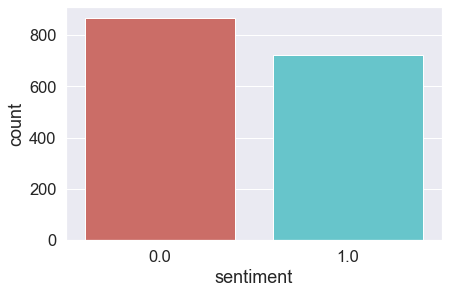

In [33]:
tweets = data_s.copy()
tweet_duplicate = data[tweets.isin(tweets[tweets.duplicated(subset=['user','text'],keep="last")])].sort_values("text")
val_count = tweet_duplicate['sentiment'].value_counts()
display(val_count)
sns.set(font_scale=1.5)
countplt=sns.countplot(x="sentiment", data= tweet_duplicate, palette ='hls')
plt.show()

In [34]:
# Group by two features
groups = data_s.groupby(['user','sentiment']).size()
#
groups_count = groups.to_frame(name = 'counts').reset_index()
#
display(groups_count.head(10))
#
A_sorted = groups_count.sort_values(["user", "counts"], ascending=True)
display(A_sorted.head(10))
# get the unique values (rows) by retaining last row
non_dups = A_sorted.drop_duplicates(subset = ["user"],keep='last')
display(non_dups.head(10))

#Get Unique Values from a Column
print(" count the number of unique values in the user column: in the dataset where label is nkow: ",data_s['user'].nunique())
#
data_unkn = data[data["sentiment"]==-1]
print(" count the number of unique values in the user column in the dataset where label is unkow: ",data_unkn['user'].nunique())


,user,sentiment,counts
0,007peter,0,14
1,007peter,1,1
2,12gaBrowningGal,0,7
3,12gaBrowningGal,1,10
4,15Stepz,1,16
5,16_MileyCyrus,0,36
6,16_MileyCyrus,1,38
7,18percentgrey,0,2
8,18percentgrey,1,37
9,19c816tf9227,1,47


,user,sentiment,counts
1,007peter,1,1
0,007peter,0,14
2,12gaBrowningGal,0,7
3,12gaBrowningGal,1,10
4,15Stepz,1,16
5,16_MileyCyrus,0,36
6,16_MileyCyrus,1,38
7,18percentgrey,0,2
8,18percentgrey,1,37
9,19c816tf9227,1,47


,user,sentiment,counts
0,007peter,0,14
3,12gaBrowningGal,1,10
4,15Stepz,1,16
6,16_MileyCyrus,1,38
8,18percentgrey,1,37
9,19c816tf9227,1,47
10,19fischi75,0,42
12,1ChazD,1,17
13,1Ele,0,12
15,1azylizzie,0,10


 count the number of unique values in the user column: in the dataset where label is nkow:  10647
 count the number of unique values in the user column in the dataset where label is unkow:  0


## 1. Preprocessing Dataset

In [35]:
data.shape

(224994, 3)

### Note
- **[apply](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) helps to apply custom functions to the Dataframe**
- ** We can also use word_tokenize for tokenizing**

## Remove punctuation

In [36]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
#Function to remove Punctuation
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct

#text preprocessing helper functions:
#clean_text() function applies a first round of text cleaning techniques.the function 
#text_preprocessing then takes in the processed text from the clean_text() function and applies techniques like tokenization and stop word removal.

def text_preprocessing(tweet):
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    tweet = tweet.lower()
    # Replace all URls with 'URL'-- >''
    tweet = re.sub(urlPattern,'',tweet)
    # Replace all emojis.
    # Replace @USERNAME to 'USER'.-->''
    tweet = re.sub(userPattern,'', tweet)        
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    #
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokenized_text = tokenizer.tokenize(tweet)
    #combined text 
    combined_text = ' '.join(tokenized_text)
    return combined_text

data['body_text_clean'] = data['text'].apply(lambda x: text_preprocessing(x))

data.head()

,sentiment,user,text,body_text_clean
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",yes talking helps a lot going through it there...
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,sunshine livingg itt imma lie on the grass lis...
2,1,yaseminx3,@PleaseBeMine Something for your iphone,something for your iphone
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,couldn t get in to the after party
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,aww is andy being mean again now i want maccas


## Tokenization

In [38]:
import re

# Function to Tokenize words
def tokenize(text):
    tokens = re.split('\W+', text) #W+ means that either a word character (A-Za-z0-9_) or a dash (-) can go there.
    return tokens

data['body_text_tokenized'] = data['body_text_clean'].apply(lambda x: tokenize(x.lower())) 
#We convert to lower as Python is case-sensitive. 

data.head()

,sentiment,user,text,body_text_clean,body_text_tokenized
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",yes talking helps a lot going through it there...,"[yes, talking, helps, a, lot, going, through, ..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,sunshine livingg itt imma lie on the grass lis...,"[sunshine, livingg, itt, imma, lie, on, the, g..."
2,1,yaseminx3,@PleaseBeMine Something for your iphone,something for your iphone,"[something, for, your, iphone]"
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,couldn t get in to the after party,"[couldn, t, get, in, to, the, after, party]"
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,aww is andy being mean again now i want maccas,"[aww, is, andy, being, mean, again, now, i, wa..."


## Remove stopwords

In [39]:
import nltk
stopword = nltk.corpus.stopwords.words('english')# All English Stopwords

In [40]:
# Function to remove Stopwords
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]# To remove all stopwords
    return text

data['body_text_nostop'] = data['body_text_tokenized'].apply(lambda x: remove_stopwords(x))
data.head()

,sentiment,user,text,body_text_clean,body_text_tokenized,body_text_nostop
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",yes talking helps a lot going through it there...,"[yes, talking, helps, a, lot, going, through, ...","[yes, talking, helps, lot, going, judgment, se..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,sunshine livingg itt imma lie on the grass lis...,"[sunshine, livingg, itt, imma, lie, on, the, g...","[sunshine, livingg, itt, imma, lie, grass, lis..."
2,1,yaseminx3,@PleaseBeMine Something for your iphone,something for your iphone,"[something, for, your, iphone]","[something, iphone]"
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,couldn t get in to the after party,"[couldn, t, get, in, to, the, after, party]","[get, party]"
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,aww is andy being mean again now i want maccas,"[aww, is, andy, being, mean, again, now, i, wa...","[aww, andy, mean, want, maccas]"


In [41]:
#Remove tweets with length zero after cleannig

## Preprocessing Data: Using Stemming

In [42]:
ps = nltk.PorterStemmer()

def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

data['body_text_stemmed'] = data['body_text_nostop'].apply(lambda x: stemming(x))

data.head()

,sentiment,user,text,body_text_clean,body_text_tokenized,body_text_nostop,body_text_stemmed
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",yes talking helps a lot going through it there...,"[yes, talking, helps, a, lot, going, through, ...","[yes, talking, helps, lot, going, judgment, se...","[ye, talk, help, lot, go, judgment, sentenc, e..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,sunshine livingg itt imma lie on the grass lis...,"[sunshine, livingg, itt, imma, lie, on, the, g...","[sunshine, livingg, itt, imma, lie, grass, lis...","[sunshin, livingg, itt, imma, lie, grass, list..."
2,1,yaseminx3,@PleaseBeMine Something for your iphone,something for your iphone,"[something, for, your, iphone]","[something, iphone]","[someth, iphon]"
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,couldn t get in to the after party,"[couldn, t, get, in, to, the, after, party]","[get, party]","[get, parti]"
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,aww is andy being mean again now i want maccas,"[aww, is, andy, being, mean, again, now, i, wa...","[aww, andy, mean, want, maccas]","[aww, andi, mean, want, macca]"


## Preprocessing Data: Using a Lemmatizer

In [43]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

data['body_text_lemmatized'] = data['body_text_nostop'].apply(lambda x: lemmatizing(x))

data.head(10)

,sentiment,user,text,body_text_clean,body_text_tokenized,body_text_nostop,body_text_stemmed,body_text_lemmatized
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",yes talking helps a lot going through it there...,"[yes, talking, helps, a, lot, going, through, ...","[yes, talking, helps, lot, going, judgment, se...","[ye, talk, help, lot, go, judgment, sentenc, e...","[yes, talking, help, lot, going, judgment, sen..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,sunshine livingg itt imma lie on the grass lis...,"[sunshine, livingg, itt, imma, lie, on, the, g...","[sunshine, livingg, itt, imma, lie, grass, lis...","[sunshin, livingg, itt, imma, lie, grass, list...","[sunshine, livingg, itt, imma, lie, grass, lis..."
2,1,yaseminx3,@PleaseBeMine Something for your iphone,something for your iphone,"[something, for, your, iphone]","[something, iphone]","[someth, iphon]","[something, iphone]"
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,couldn t get in to the after party,"[couldn, t, get, in, to, the, after, party]","[get, party]","[get, parti]","[get, party]"
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,aww is andy being mean again now i want maccas,"[aww, is, andy, being, mean, again, now, i, wa...","[aww, andy, mean, want, maccas]","[aww, andi, mean, want, macca]","[aww, andy, mean, want, maccas]"
5,0,purplesolleile,I'm getting so anxious about tomorrow. Help?,i m getting so anxious about tomorrow help,"[i, m, getting, so, anxious, about, tomorrow, ...","[getting, anxious, tomorrow, help]","[get, anxiou, tomorrow, help]","[getting, anxious, tomorrow, help]"
6,1,blue_rose,@nocturnalie The Doctors and Masters are screw...,the doctors and masters are screwed then,"[the, doctors, and, masters, are, screwed, then]","[doctors, masters, screwed]","[doctor, master, screw]","[doctor, master, screwed]"
7,0,NGowers,@manxmidge barely been used.,barely been used,"[barely, been, used]","[barely, used]","[bare, use]","[barely, used]"
8,0,wonderpetunia,hahah it can't work on livejournal,hahah it can t work on livejournal,"[hahah, it, can, t, work, on, livejournal]","[hahah, work, livejournal]","[hahah, work, livejourn]","[hahah, work, livejournal]"
9,0,spaulds1,@socaldavel Ugh! Sorry ur sick! Fresh fruit d...,ugh sorry ur sick fresh fruit drinks amp vits ...,"[ugh, sorry, ur, sick, fresh, fruit, drinks, a...","[ugh, sorry, ur, sick, fresh, fruit, drinks, a...","[ugh, sorri, ur, sick, fresh, fruit, drink, am...","[ugh, sorry, ur, sick, fresh, fruit, drink, am..."


In [44]:
import string
string.punctuation
#Function to remove Punctuation
def remove_punct(text):
    text_nopunct = " ".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct

# body_text_stemmed ------> text
data['text_stemmed'] = data['body_text_stemmed'].apply(lambda x: remove_punct(x))

# body_text_lemmatized ---> text
data['text_lemmatized'] = data['body_text_lemmatized'].apply(lambda x: remove_punct(x))

data.head()

,sentiment,user,text,body_text_clean,body_text_tokenized,body_text_nostop,body_text_stemmed,body_text_lemmatized,text_stemmed,text_lemmatized
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",yes talking helps a lot going through it there...,"[yes, talking, helps, a, lot, going, through, ...","[yes, talking, helps, lot, going, judgment, se...","[ye, talk, help, lot, go, judgment, sentenc, e...","[yes, talking, help, lot, going, judgment, sen...",ye talk help lot go judgment sentenc end quot ...,yes talking help lot going judgment sentence e...
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,sunshine livingg itt imma lie on the grass lis...,"[sunshine, livingg, itt, imma, lie, on, the, g...","[sunshine, livingg, itt, imma, lie, grass, lis...","[sunshin, livingg, itt, imma, lie, grass, list...","[sunshine, livingg, itt, imma, lie, grass, lis...",sunshin livingg itt imma lie grass listen oasi...,sunshine livingg itt imma lie grass listening ...
2,1,yaseminx3,@PleaseBeMine Something for your iphone,something for your iphone,"[something, for, your, iphone]","[something, iphone]","[someth, iphon]","[something, iphone]",someth iphon,something iphone
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,couldn t get in to the after party,"[couldn, t, get, in, to, the, after, party]","[get, party]","[get, parti]","[get, party]",get parti,get party
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,aww is andy being mean again now i want maccas,"[aww, is, andy, being, mean, again, now, i, wa...","[aww, andy, mean, want, maccas]","[aww, andi, mean, want, macca]","[aww, andy, mean, want, maccas]",aww andi mean want macca,aww andy mean want maccas


# Remove tweets with length zero after clearning

In [47]:
data_s = data.copy()
data_s['len_text_nostop'] = data_s['body_text_nostop'].apply(len)
tweets_null = data_s[data_s["len_text_nostop"]==0]
print("shape of dataset with length == 0",tweets_null.shape)
data_clean = data_s[data_s["len_text_nostop"]>0]
print("shape of dataset with length >= 1",data_clean.shape)

shape of dataset with length == 0 (807, 11)
shape of dataset with length >= 1 (224187, 11)


# Evaluate Model Function

In [66]:
def Evaluate(yact, ypred):
    return f1_score(yact, ypred, average="macro")

def Evaluate_model(model,X_test_s,y_test_s):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test_s)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test_s, y_pred))
    
    # Print the evaluation f1_macro metrics for the dataset.
    acc = Evaluate(y_test_s, y_pred)
    print(f"F1_macro(behavior of the model with the new data): ",acc)
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test_s, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    heat_map = sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
  
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    #plt.savefig("confusion_matrix.png")
    plt.show()
    print(' ') 
    return acc

## <a name="p7">Splitting the Dataset</a>
The Preprocessed Data is divided into 2 sets of data:
* **Training Data:** The dataset upon which the model would be trained on. Contains 70% data.
* **Test Data:** The dataset upon which the model would be tested against. Contains 30% data.

In [63]:
def Splitting_the_Data(feature):
    #Store dataset in X and y
    X ,y = data_clean.loc[:,feature],data_clean['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y, shuffle = True, random_state = 8)
    print("First Split: ")
    # summarize after splitting dataset
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    print("X_train.shape : ",X_train.shape)
    print("y_train.shape : ",y_train.shape)
    print("X_test shape: {}".format(X_test.shape))
    print("y_test shape: {}".format(y_test.shape))
    return  X_train, X_test, y_train, y_test 

## <a name="p8">Creating and Evaluating Models</a>

We're creating 3 different types of model for our sentiment analysis problem: 
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**
* **Naive Bayes Classifier (MB)**
* **Naive Bayes Classifier (NB)**

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative** Predictions. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

In [92]:
BaseModels=[LogisticRegression(),RidgeClassifier(),
            LinearSVC(),SGDClassifier(),MultinomialNB(),
            BernoulliNB(alpha = 2)]#,RandomForestClassifier()]

# Methods of Tranforming dataset:

## <a name="p11">1.Vectorizing Data: Bag-Of-Words</a>

       Vectorization is jargon for a classic approach of converting input data from its raw format (i.e. text ) into vectors of real numbers which is the format that ML models support.
  
        In Machine Learning, vectorization is a step in feature extraction. The idea is to get some distinct features out of the text for the model to train on, by converting text to numerical vectors.
        
## <a name="p12">Apply CountVectorizer (N-Grams)</a>

        Count vectorizer bag of words feature extraction
        The following code will show the count vectorizer for a bag of words:
        Vectorizing Raw Data: N-Grams
### Example of N-Grams 
"plata o plomo means silver or lead"

| n | Name      | Tokens                                                         |
|---|-----------|----------------------------------------------------------------|
| 2 | bigram    | ["plata o", "o plomo", "plomo means", "means silver", "silver or","or lead"]      |
| 3 | trigram   | ["plata o plomo", "o plomo means", "plomo means silver", "means silver or ", "silver or lead"] |
        
        

# Vectorizing data using text_lemmatized or text_stemmed column

Feature text_lemmatized:
First Split: 
>Train: 0=66152, 1=90778, Test: 0=28352, 1=38905
X_train.shape :  (156930,)
y_train.shape :  (156930,)
X_test shape: (67257,)
y_test shape: (67257,)
Transform train data:
X_train_counts: (156930, 56209)
X_train_tfidf: (156930, 56209)
Transform test data:
X_test_counts: (67257, 56209)
X_test_tfidf: (67257, 56209)
Train Model with data:
We are train model with LogisticRegression()
              precision    recall  f1-score   support

           0       0.76      0.67      0.71     28352
           1       0.78      0.84      0.81     38905

    accuracy                           0.77     67257
   macro avg       0.77      0.75      0.76     67257
weighted avg       0.77      0.77      0.77     67257

F1_macro(behavior of the model with the new data):  0.7585680665324831


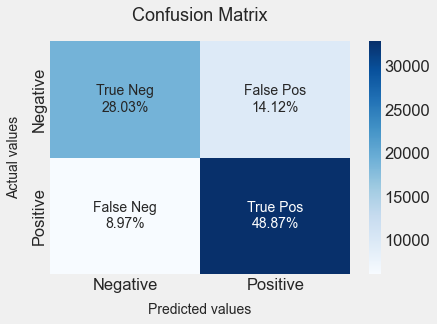

 
End Training
We are train model with RidgeClassifier()
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     28352
           1       0.77      0.83      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.76      0.75      0.75     67257
weighted avg       0.76      0.76      0.76     67257

F1_macro(behavior of the model with the new data):  0.7489659908263898


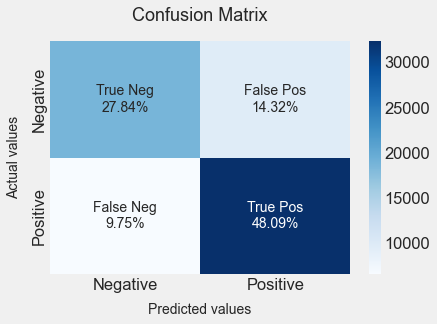

 
End Training
We are train model with LinearSVC()
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     28352
           1       0.77      0.82      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.75      0.74      0.75     67257
weighted avg       0.76      0.76      0.76     67257

F1_macro(behavior of the model with the new data):  0.7474038861074133


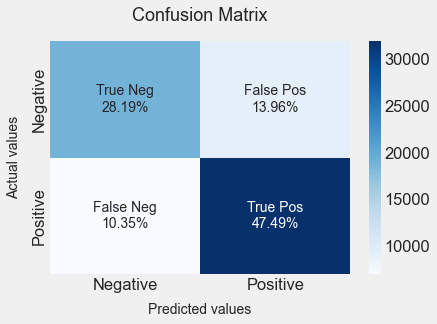

 
End Training
We are train model with SGDClassifier()
              precision    recall  f1-score   support

           0       0.79      0.55      0.65     28352
           1       0.73      0.90      0.81     38905

    accuracy                           0.75     67257
   macro avg       0.76      0.72      0.73     67257
weighted avg       0.76      0.75      0.74     67257

F1_macro(behavior of the model with the new data):  0.7272980161148335


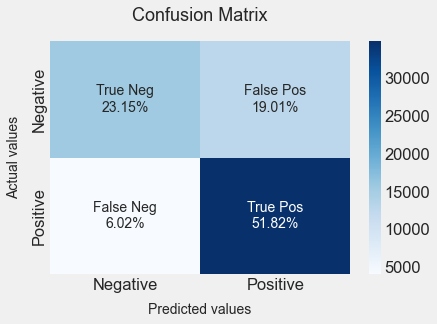

 
End Training
We are train model with MultinomialNB()
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     28352
           1       0.74      0.88      0.80     38905

    accuracy                           0.75     67257
   macro avg       0.76      0.73      0.73     67257
weighted avg       0.76      0.75      0.74     67257

F1_macro(behavior of the model with the new data):  0.7333605608872238


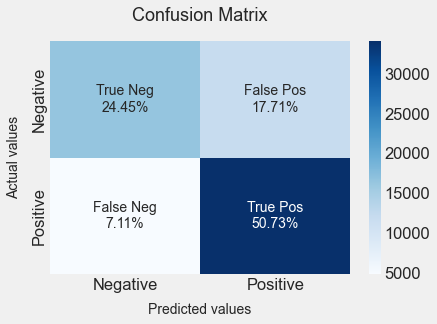

 
End Training
We are train model with BernoulliNB(alpha=2)
              precision    recall  f1-score   support

           0       0.77      0.61      0.68     28352
           1       0.75      0.86      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.76      0.74      0.74     67257
weighted avg       0.76      0.76      0.75     67257

F1_macro(behavior of the model with the new data):  0.7399141182897717


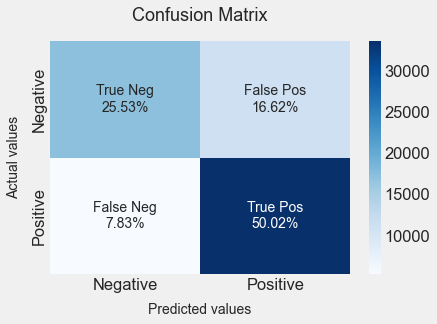

 
End Training
Feature text_stemmed:
First Split: 
>Train: 0=66152, 1=90778, Test: 0=28352, 1=38905
X_train.shape :  (156930,)
y_train.shape :  (156930,)
X_test shape: (67257,)
y_test shape: (67257,)
Transform train data:
X_train_counts: (156930, 47711)
X_train_tfidf: (156930, 47711)
Transform test data:
X_test_counts: (67257, 47711)
X_test_tfidf: (67257, 47711)
Train Model with data:
We are train model with LogisticRegression()
              precision    recall  f1-score   support

           0       0.76      0.67      0.71     28352
           1       0.78      0.84      0.81     38905

    accuracy                           0.77     67257
   macro avg       0.77      0.75      0.76     67257
weighted avg       0.77      0.77      0.77     67257

F1_macro(behavior of the model with the new data):  0.7578554575163154


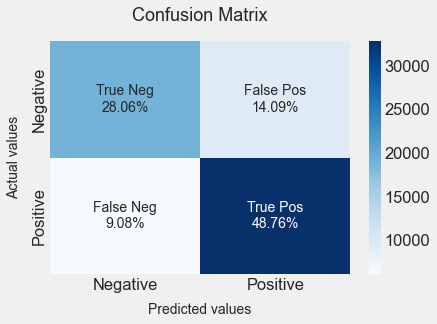

 
End Training
We are train model with RidgeClassifier()
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     28352
           1       0.77      0.83      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.76      0.75      0.75     67257
weighted avg       0.76      0.76      0.76     67257

F1_macro(behavior of the model with the new data):  0.7495506681783396


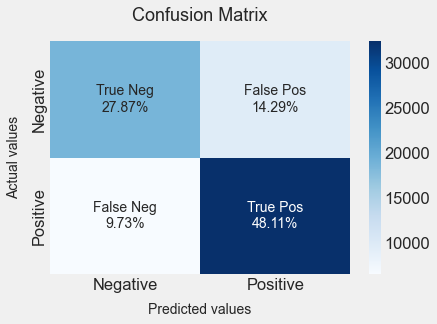

 
End Training
We are train model with LinearSVC()
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     28352
           1       0.77      0.82      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.75      0.75      0.75     67257
weighted avg       0.76      0.76      0.76     67257

F1_macro(behavior of the model with the new data):  0.7479033462440926


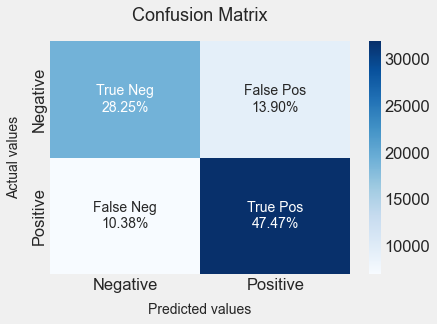

 
End Training
We are train model with SGDClassifier()
              precision    recall  f1-score   support

           0       0.79      0.56      0.66     28352
           1       0.74      0.89      0.81     38905

    accuracy                           0.75     67257
   macro avg       0.76      0.73      0.73     67257
weighted avg       0.76      0.75      0.74     67257

F1_macro(behavior of the model with the new data):  0.7315740279038307


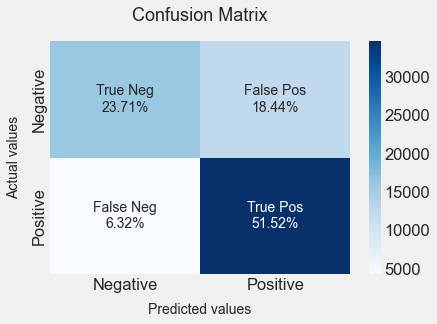

 
End Training
We are train model with MultinomialNB()
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     28352
           1       0.74      0.88      0.80     38905

    accuracy                           0.75     67257
   macro avg       0.76      0.73      0.73     67257
weighted avg       0.75      0.75      0.74     67257

F1_macro(behavior of the model with the new data):  0.7324684347292112


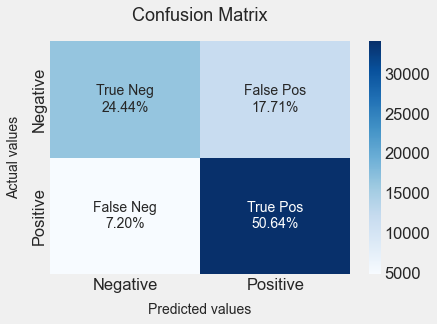

 
End Training
We are train model with BernoulliNB(alpha=2)
              precision    recall  f1-score   support

           0       0.76      0.62      0.68     28352
           1       0.75      0.86      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.76      0.74      0.74     67257
weighted avg       0.76      0.76      0.75     67257

F1_macro(behavior of the model with the new data):  0.7410410106242926


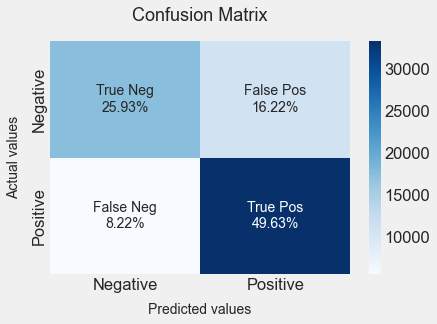

 
End Training


In [91]:
clean_features = ['text_lemmatized','text_stemmed']
df = pd.DataFrame()
results = {}
for feature in clean_features:
    print(f"Feature {feature}:")
    results = {}
    X_train, X_test, y_train, y_test = Splitting_the_Data(feature)
    count_vect = CountVectorizer(stop_words='english')
    transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
    print("Transform train data:")
    X_train_counts = count_vect.fit_transform(X_train)
    X_train_tfidf = transformer.fit_transform(X_train_counts)
    print(f"X_train_counts:",X_train_counts.shape)
    print(f"X_train_tfidf:",X_train_tfidf.shape)
    print("Transform test data:")
    X_test_counts = count_vect.transform(X_test)
    X_test_tfidf = transformer.transform(X_test_counts)
    print(f"X_test_counts:",X_test_counts.shape)
    print(f"X_test_tfidf:",X_test_tfidf.shape)
    print("Train Model with data:")
    for model in BaseModels:
        print(f"We are train model with {model}")
        model.fit(X_train_tfidf,y_train)
        acc = Evaluate_model(model,X_test_tfidf,y_test)
        results[model] = acc
        print("End Training")
    df=df.append(pd.DataFrame(results, index =['F1_Score']))

In [93]:
print("Evaluation Metric:")
df.set_axis(['F1_Score_Lem', 'F1_Score_Stem'], inplace=True)
display(df)

Evaluation Metric:


,LogisticRegression(),RidgeClassifier(),LinearSVC(),SGDClassifier(),MultinomialNB(),BernoulliNB(alpha=2)
F1_Score_Lem,0.758568,0.748966,0.747404,0.727298,0.733361,0.739914
F1_Score_Stem,0.757855,0.749551,0.747903,0.731574,0.732468,0.741041


## <a name="p15">2.Vectorizing Raw Data: TF-IDF</a>
## TF-IDF Vectoriser
**TF-IDF indicates what the importance of the word is in order to understand the document or dataset.** Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **X_train** dataset. 

**ngram_range**  is the range of number of words in a sequence. *[e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]*

**max_features** specifies the number of features to consider. *[Ordered by feature frequency across the corpus]*.

### TF-IDF

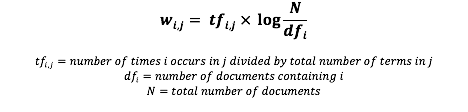

### Apply TfidfVectorizer
* **TF-IDF**
* **TF** = (number of times term appear in a document)/(Number of terms in dcoument).
* **IDF**= log(N/n)-N is nummber of documents and n is number of documents a term has appeared in.
* **TF-IDF**= TF * IDF.

# TF-IDF Vectoriser data using text_lemmatized or text_stemmed column

Feature text_lemmatized:
First Split: 
>Train: 0=66152, 1=90778, Test: 0=28352, 1=38905
X_train.shape :  (156930,)
y_train.shape :  (156930,)
X_test shape: (67257,)
y_test shape: (67257,)
Vectoriser fitted.
No. of feature_words:  500000
Transform train data:
Data Transformed.
Train Model with data:
We are train model with LogisticRegression()
              precision    recall  f1-score   support

           0       0.76      0.67      0.71     28352
           1       0.78      0.84      0.81     38905

    accuracy                           0.77     67257
   macro avg       0.77      0.75      0.76     67257
weighted avg       0.77      0.77      0.77     67257

F1_macro(behavior of the model with the new data):  0.7578554575163154


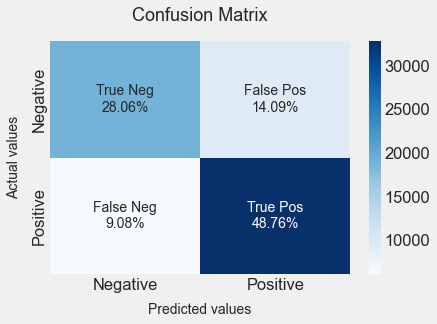

 
End Training
We are train model with RidgeClassifier()
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     28352
           1       0.77      0.83      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.76      0.75      0.75     67257
weighted avg       0.76      0.76      0.76     67257

F1_macro(behavior of the model with the new data):  0.7495506681783396


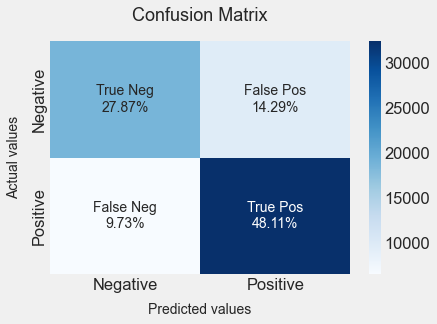

 
End Training
We are train model with LinearSVC()
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     28352
           1       0.77      0.82      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.75      0.75      0.75     67257
weighted avg       0.76      0.76      0.76     67257

F1_macro(behavior of the model with the new data):  0.7479033462440926


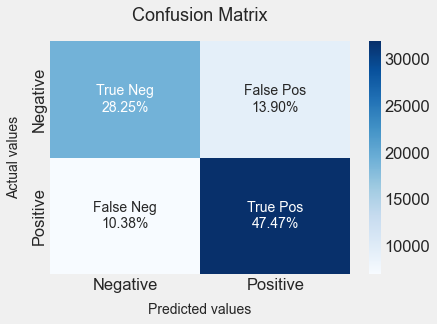

 
End Training
We are train model with SGDClassifier()
              precision    recall  f1-score   support

           0       0.79      0.57      0.66     28352
           1       0.74      0.89      0.81     38905

    accuracy                           0.75     67257
   macro avg       0.76      0.73      0.73     67257
weighted avg       0.76      0.75      0.74     67257

F1_macro(behavior of the model with the new data):  0.7327117843376489


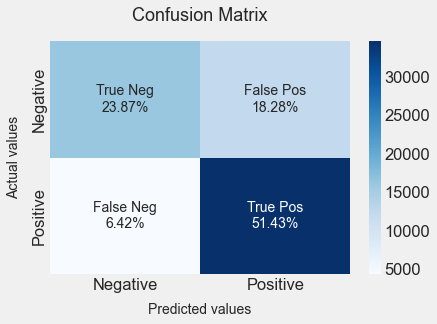

 
End Training
We are train model with MultinomialNB()
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     28352
           1       0.74      0.88      0.80     38905

    accuracy                           0.75     67257
   macro avg       0.76      0.73      0.73     67257
weighted avg       0.75      0.75      0.74     67257

F1_macro(behavior of the model with the new data):  0.7324684347292112


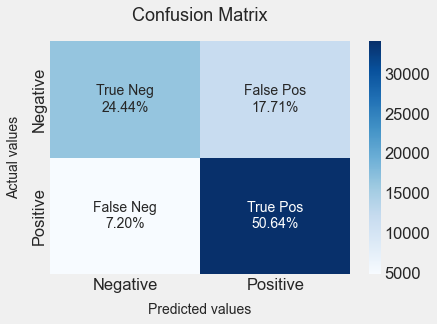

 
End Training
We are train model with BernoulliNB(alpha=2)
              precision    recall  f1-score   support

           0       0.76      0.62      0.68     28352
           1       0.75      0.86      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.76      0.74      0.74     67257
weighted avg       0.76      0.76      0.75     67257

F1_macro(behavior of the model with the new data):  0.7410410106242926


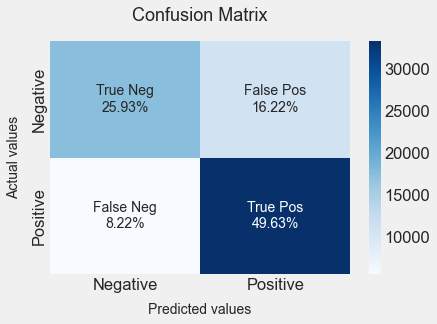

 
End Training
Feature text_stemmed:
First Split: 
>Train: 0=66152, 1=90778, Test: 0=28352, 1=38905
X_train.shape :  (156930,)
y_train.shape :  (156930,)
X_test shape: (67257,)
y_test shape: (67257,)
Vectoriser fitted.
No. of feature_words:  500000
Transform train data:
Data Transformed.
Train Model with data:
We are train model with LogisticRegression()
              precision    recall  f1-score   support

           0       0.76      0.67      0.71     28352
           1       0.78      0.84      0.81     38905

    accuracy                           0.77     67257
   macro avg       0.77      0.75      0.76     67257
weighted avg       0.77      0.77      0.77     67257

F1_macro(behavior of the model with the new data):  0.7578554575163154


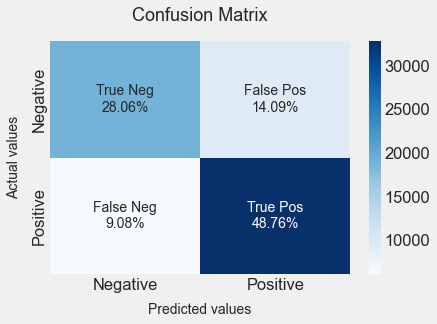

 
End Training
We are train model with RidgeClassifier()
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     28352
           1       0.77      0.83      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.76      0.75      0.75     67257
weighted avg       0.76      0.76      0.76     67257

F1_macro(behavior of the model with the new data):  0.7495506681783396


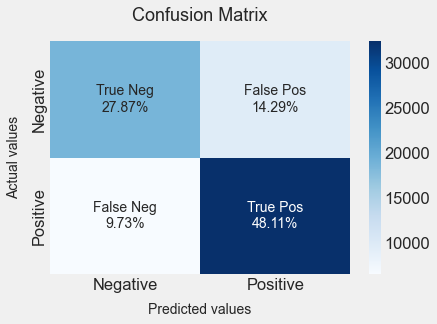

 
End Training
We are train model with LinearSVC()
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     28352
           1       0.77      0.82      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.75      0.75      0.75     67257
weighted avg       0.76      0.76      0.76     67257

F1_macro(behavior of the model with the new data):  0.7479033462440926


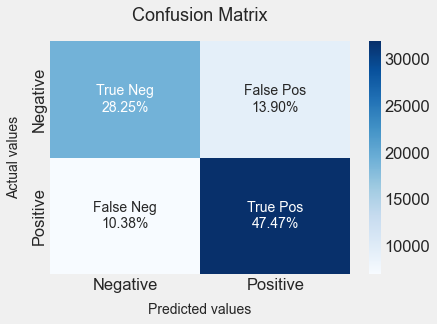

 
End Training
We are train model with SGDClassifier()
              precision    recall  f1-score   support

           0       0.79      0.57      0.66     28352
           1       0.74      0.89      0.81     38905

    accuracy                           0.75     67257
   macro avg       0.76      0.73      0.73     67257
weighted avg       0.76      0.75      0.74     67257

F1_macro(behavior of the model with the new data):  0.7334905873012181


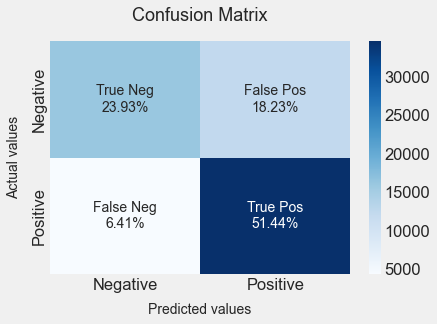

 
End Training
We are train model with MultinomialNB()
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     28352
           1       0.74      0.88      0.80     38905

    accuracy                           0.75     67257
   macro avg       0.76      0.73      0.73     67257
weighted avg       0.75      0.75      0.74     67257

F1_macro(behavior of the model with the new data):  0.7324684347292112


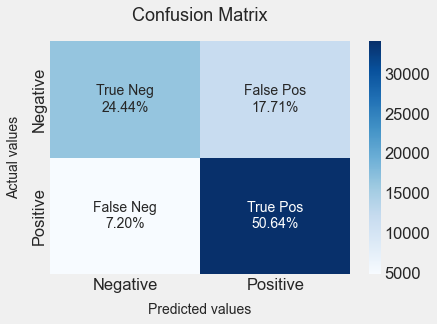

 
End Training
We are train model with BernoulliNB(alpha=2)
              precision    recall  f1-score   support

           0       0.76      0.62      0.68     28352
           1       0.75      0.86      0.80     38905

    accuracy                           0.76     67257
   macro avg       0.76      0.74      0.74     67257
weighted avg       0.76      0.76      0.75     67257

F1_macro(behavior of the model with the new data):  0.7410410106242926


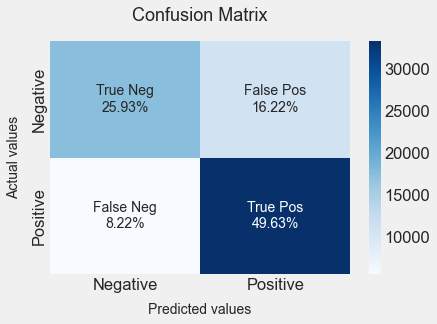

 
End Training


In [95]:
clean_features = ['text_lemmatized','text_stemmed']
df = pd.DataFrame()
results = {}
for feature in clean_features:
    print(f"Feature {feature}:")
    results = {}
    X_train, X_test, y_train, y_test = Splitting_the_Data(feature)
    vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
    vectoriser.fit(X_train)
    print(f'Vectoriser fitted.')
    print('No. of feature_words: ', len(vectoriser.get_feature_names()))
    print("Transform train data:") #Tranforming the dataset
    X_train = vectoriser.transform(X_train)
    X_test  = vectoriser.transform(X_test)
    print(f'Data Transformed.')
    print("Train Model with data:")
    for model in BaseModels:
        print(f"We are train model with {model}")
        model.fit(X_train_tfidf,y_train)
        acc = Evaluate_model(model,X_test_tfidf,y_test)
        results[model] = acc
        print("End Training")
    df=df.append(pd.DataFrame(results, index =['F1_Score']))

In [96]:
print("Evaluation Metric:")
df.set_axis(['F1_Score_Lem', 'F1_Score_Stem'], inplace=True)
display(df)

Evaluation Metric:


,LogisticRegression(),RidgeClassifier(),LinearSVC(),SGDClassifier(),MultinomialNB(),BernoulliNB(alpha=2)
F1_Score_Lem,0.757855,0.749551,0.747903,0.732712,0.732468,0.741041
F1_Score_Stem,0.757855,0.749551,0.747903,0.733491,0.732468,0.741041


# Conclusion
Among above 6 classifiers model, Logistic Regression Classifier delivered exceptionally good results.LinearSVC stands as the second best model. I applied various combination of hyperparameters forLogistic Regression to reach to the optimal solution.

## <a name="p16">Hyperparameter Tuning for LogisticRegression</a>

# ''' PIPELINE COUNTVECTORIZER + ONEHOTENCODING '''

In [104]:
def Preprocessing_with_Bag_of_Words(text_features,categorical_features):
    Bag_of_Words = CountVectorizer(ngram_range=(1,3),max_features =50000) ##max_df=0.70,min_df=0.001,max_features =50000,stop_words='english'
    #colonna per tfidf or Count vectorizer
    text_transformer = Pipeline(steps=[('CountVectorizer',Bag_of_Words)])
    #colonne encoding using ---->  One Hot Encoding
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    #
    preprocessor = ColumnTransformer( transformers=[
                                                   ('text', text_transformer,text_features),
                                                   ('cat', categorical_transformer,[categorical_features])
                                                   ])
    return  preprocessor

print("Create preprocessing")
Bag_of_Words_Preprocessor = Preprocessing_with_Bag_of_Words('text_lemmatized','user')   
print("Create the pipeline for LogisticRegression: ")
LogReg_pipeline = Pipeline(steps=[('Preprocessing', Bag_of_Words_Preprocessor),
                                  ('classifier', LogisticRegression())
                                 ])
print("Train the model:")
features=['user','text_lemmatized']
#Store dataset in X and y
X ,y = data_clean.loc[:,features],data_clean['sentiment']
X_train, X_test, y_train, y_test = Splitting_the_Data(features)
LogReg_pipeline.fit(X_train, y_train)
score = LogReg_pipeline.score(X_test, y_test)
print("Accuracy:",score)

# Set grid search params
Create preprocessing
Create the pipeline for LogisticRegression: 
Train the model:
First Split: 
>Train: 0=66152, 1=90778, Test: 0=28352, 1=38905
X_train.shape :  (156930, 2)
y_train.shape :  (156930,)
X_test shape: (67257, 2)
y_test shape: (67257,)
Accuracy: 0.8079456413458822


# grid search on a pipeline

In [111]:
from sklearn.pipeline import make_pipeline
# create a pipeline
LogReg_pipeline = Pipeline(steps=[('Preprocessing', Bag_of_Words_Preprocessor),
                                  ('classifier', LogisticRegression())
                                 ])
print("# Set grid search params for LogisticRegression'")
# create the search grid.
# Pipeline hyper-parameters are specified as <step name>__<hyper-parameter name>
#Setting the range for class weights
weights = np.linspace(0.0,0.99,5)
param_grid = [{
    'classifier__penalty': ['l1', 'l2','elasticnet','none'],
    'classifier__C': np.logspace(-3,3,5)
    }]
#weights = np.linspace(0.0,0.99,5)
#grid_params_lr = [{
#'Logreg__penalty': ['l1', 'l2','elasticnet','none'],
#'Logreg__C': np.logspace(-3,3,15),
#'Logreg__solver': ['lbfgs','newton-cg','liblinear','sag','saga','none'],
#'Logreg__max_iter' : [5,10,20,50,70,90,100], #,150 ,200],
#'Logreg__class_weight' : [{0:x, 1:1.0-x} for x in weights]
#}] 
# Instantiate grid-search
grid = GridSearchCV(LogReg_pipeline, param_grid, cv=5,verbose=1,n_jobs=-1)
# run the grid-search and report results
grid.fit(X_train, y_train)
print("Best Configuration:",grid.best_params_)
print("Test accuracy:",grid.score(X_test, y_test))

# Set grid search params for LogisticRegression'
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Configuration: {'classifier__C': 1.0, 'classifier__penalty': 'l2'}
Test accuracy: 0.8079456413458822


## <a name="p17">Hyperparameter Tuning for MultinomialNB</a>

In [113]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

X_train, X_test, y_train, y_test = Splitting_the_Data('text_lemmatized')
clf = GridSearchCV(text_clf, tuned_parameters, cv=5)
clf.fit(X_train,y_train)
print(classification_report(y_test, clf.predict(X_test), digits=4))

First Split: 
>Train: 0=66152, 1=90778, Test: 0=28352, 1=38905
X_train.shape :  (156930,)
y_train.shape :  (156930,)
X_test shape: (67257,)
y_test shape: (67257,)
              precision    recall  f1-score   support

           0     0.7571    0.6469    0.6977     28352
           1     0.7674    0.8487    0.8060     38905

    accuracy                         0.7637     67257
   macro avg     0.7622    0.7478    0.7518     67257
weighted avg     0.7630    0.7637    0.7603     67257

